# Initialiazation Packages

In [1]:
using LinearAlgebra
using PyPlot
using PyCall
using LaTeXStrings
using QuantumToolbox, Roots
using DelimitedFiles, NLsolve
using Random, Distributions, Dates, Polynomials, StatsBase 
using JLD

In [2]:
using Pkg
Pkg.activate("..")

include("../src/Closed_2KPOs_QTB_functions.jl")
using .Coupled_KPOs_QTB_functions

  Activating project at `c:\Users\edson\Desktop\Research\Kerr_system\Coupled_KPOs`


## Leakage from 2 Qubits gate $XX(\pi/2)$: Dynamics

From the coupling between the KPOs, it is possible to perform the $XX(\pi/2)$ gate.

In [3]:
N = 100
Δ1, K1, ξ11, ξ21, Δ2, K2, ξ12, ξ22, γ = p =  1.0, 1., 0., 5., 1.0, 1., 0., 5., 1.;

E_S_even, ψ_S_even, E_A_even, ψ_A_even, E_S_odd, ψ_S_odd, E_A_odd, ψ_A_odd = Coupled_kerr_equiv(p, N);
#Organizing 
all_energies = vcat(real.(E_S_even), real.(E_A_even), real.(E_S_odd), real.(E_A_odd));
all_states = hcat(ψ_S_even, ψ_A_even, ψ_S_odd, ψ_A_odd);
# Get sorting indices for energies (ascending order)
sorted_indices = sortperm(all_energies);
E = all_energies[sorted_indices];
ψ = all_states[:, sorted_indices];
N_states = 4000 #From Convergence test
#Fixing states below E = 0 (saddle point at (0,0,0,0))
E = E[1:N_states];
ψ = ψ[:,1:N_states];
E_unc, ψ_unc = H_un((Δ1, K1, ξ11, ξ21, Δ2, K2, ξ12, ξ22,0.), N);
ψ_0 = ψ_unc[:,1];
ψ_ideal = (ψ_unc[:,1] + 1im * ψ_unc[:,N+2])/sqrt(2);


In [4]:
#Function which finds the value of t to perform XX(pi/2) from the coupled Hamiltonian
function f_t_gate(t)
    c_j = (ψ' * ψ_0) .* exp.(-1im*E*t); 
    ψ_cj = ψ .* conj(c_j)'
    ψ_t = vec(sum(ψ_cj, dims=2))
    return abs2((ψ_0')*ψ_t) - abs2((ψ_unc[:,N+2]')*ψ_t)
end



f_t_gate (generic function with 1 method)

In [5]:
#Definitions
t_gate_guess = π/(8*γ*ξ21)
t_gate = find_zero(f_t_gate, t_gate_guess, atol = 1e-3)
t_final = 4 * t_gate
t_interval = range(0.0, t_final, length=100)
n1, n2, n = zeros(length(t_interval)), zeros(length(t_interval)), zeros(length(t_interval));
Leakage = zeros(length(t_interval));
pp_state, mm_state = zeros(length(t_interval)), zeros(length(t_interval));
t = time();
ψ_t = ψ_0 
k = 1
n1_ = repeat(0:N-1, inner=N)
n1[k] = sum(abs2.(ψ_t) .* n1_)
n2_ = repeat(0:N-1, outer=N)
n2[k] = sum(abs2.(ψ_t) .* n2_)
n[k] = n1[k] + n2[k]
pp_state[k], mm_state[k] = abs2((ψ_0')*ψ_t), abs2((ψ_unc[:,N+2]')*ψ_t)

(0.9999999999999982, 0.0)

In [6]:
for k in 2:length(t_interval)
    #Evolution trhough eigenbasis
    c_j = (ψ' * ψ_0) .* exp.(-1im*E*t_interval[k]) 
    ψ_cj = ψ .* conj(c_j)'
    ψ_t = sum(ψ_cj, dims=2)
    
    ψ_t = vec(ψ_t)
    
    n1_ = repeat(0:N-1, inner=N)
    n1[k] = sum(abs2.(ψ_t) .* n1_)
    n2_ = repeat(0:N-1, outer=N)
    n2[k] = sum(abs2.(ψ_t) .* n2_)
    n[k] = n1[k] + n2[k]
    pp_state[k], mm_state[k] = abs2((ψ_0')*ψ_t), abs2((ψ_unc[:,N+2]')*ψ_t)
    Leakage[k] = 1 - sum(abs2.(ψ_0' * ψ_t)) - abs2.(ψ_unc[:,N+2]' * ψ_t)
end

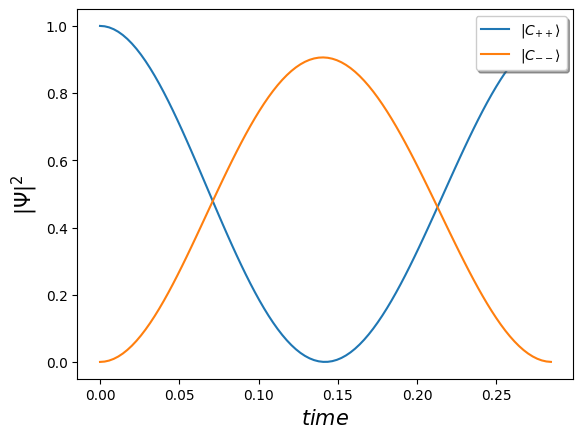

In [7]:
plot(t_interval, pp_state, label=L"|C_{++}\rangle")
plot(t_interval, mm_state, label=L"|C_{--}\rangle")
legend(fontsize=10, shadow=true, loc = "upper right");
xlabel(L"time", fontsize=15);
ylabel(L"|\Psi|^2", fontsize=15);


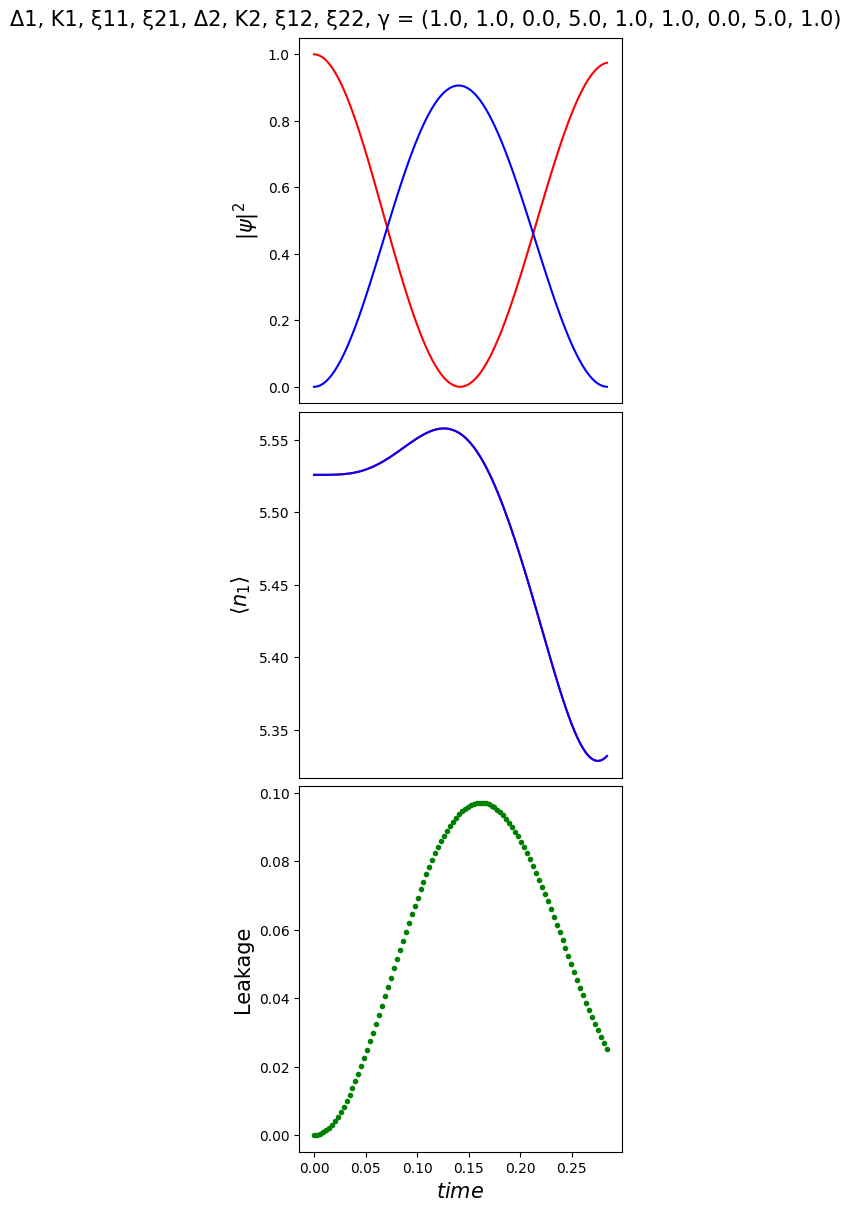

In [8]:
fig = figure(figsize=(4, 12), layout= "constrained");
gs = fig.add_gridspec(3,1);
element(i,j) = get(gs, (i,j)); # starts at 0 to N-1
slice(i,j) = pycall(pybuiltin("slice"), PyObject, i,j);
colors_ = ["red", "blue", "green", "orange", "purple", "brown", "pink", "gray", "olive", "cyan"];
labels_ = labels_states_KPOs(2);
markers_ = ["o", "v", "s", "D", "^", "<", ">", "p", "*", "h"];
elements = [[0,0], [1,0], [2, 0]];
labels_plots = [L"|ψ|^2", L"⟨n_{1}⟩", "Leakage"]
plots_list = [[pp_state, mm_state], [n1, n2, n], Leakage] 
for i in 1:3
    ax = fig.add_subplot(element(elements[i][1],elements[i][2]));
    if  i == 1 
        plot(t_interval, plots_list[i][1], color="red", label = labels_[1])
        plot(t_interval, plots_list[i][2], color="blue", label = labels_[4])
    elseif i == 2
        plot(t_interval, plots_list[i][1], color="red", label = L"⟨n_{1}⟩")
        plot(t_interval, plots_list[i][2], color="blue", label = L"⟨n_{2}⟩")
        #plot(t_interval, plots_list[i][3], color="green", label = L"⟨n⟩")
    else
        plot(t_interval, plots_list[i], ".",color=colors_[i])
    end
        #legend(fontsize=10, shadow=true, loc = "upper right");
    ylabel(labels_plots[i], fontsize=15);
    if  i == 3
        xlabel(L"time", fontsize=15);
    else
        xticks([])
    end
end
fig.suptitle("Δ1, K1, ξ11, ξ21, Δ2, K2, ξ12, ξ22, γ = $(p)", fontsize=15);
#savefig("C:/Users/edson/Desktop/Research/Kerr_system/Coupled_kerr/codes_Chemistry/Quantum_figures/Scrambling/GateXX_N_$(N)_p_$(p).png")


## Leakage vs $\gamma$ vs $\Delta$ 

$XX(\pi/2) = H(t_{gate})$. For $\Delta = 0$, we have an analytical formula. However, when $\Delta \neq 0$, we have to find the root of the following function

$$ f(t) = |\Psi_{C_{++}}(t)|^2 - |\Psi_{C_{--}}(t)|^2$$

In [3]:
N_p = 100
ps = range(0.01, 11.0, length=N_p)
F = zeros(N_p, N_p);
Leakage = zeros(N_p, N_p);
PR_sum = zeros(N_p, N_p); 
ts_gate = zeros(N_p, N_p); 
N = 100

K1, ξ11, ξ21, K2, ξ12, ξ22 =  1., 0., 5., 1., 0., 5.;
    
t = time()
for job in 1:N_p
    try
        F += load("C:/Users/edson/Desktop/Research/Kerr_system/Coupled_kerr/codes_Chemistry/data/Leakage/F_p_$(( K1, ξ11, ξ21, K2, ξ12, ξ22))_N_$(N)_job_$(job).jld")["F"];
        Leakage += load("C:/Users/edson/Desktop/Research/Kerr_system/Coupled_kerr/codes_Chemistry/data/Leakage/Leakage_p_$(( K1, ξ11, ξ21, K2, ξ12, ξ22))_N_$(N)_job_$(job).jld")["Leakage"];
        PR_sum += load("C:/Users/edson/Desktop/Research/Kerr_system/Coupled_kerr/codes_Chemistry/data/Leakage/PR_p_$(( K1, ξ11, ξ21, K2, ξ12, ξ22))_N_$(N)_job_$(job).jld")["PR_sum"];
        ts_gate += load("C:/Users/edson/Desktop/Research/Kerr_system/Coupled_kerr/codes_Chemistry/data/Leakage/Tgate_p_$(( K1, ξ11, ξ21, K2, ξ12, ξ22))_N_$(N)_job_$(job).jld")["ts_gate"];
    catch
        println("$(job)")
    end
end
println("Time elapsed: $(time() - t) seconds")

Time elapsed: 13.806999921798706 seconds


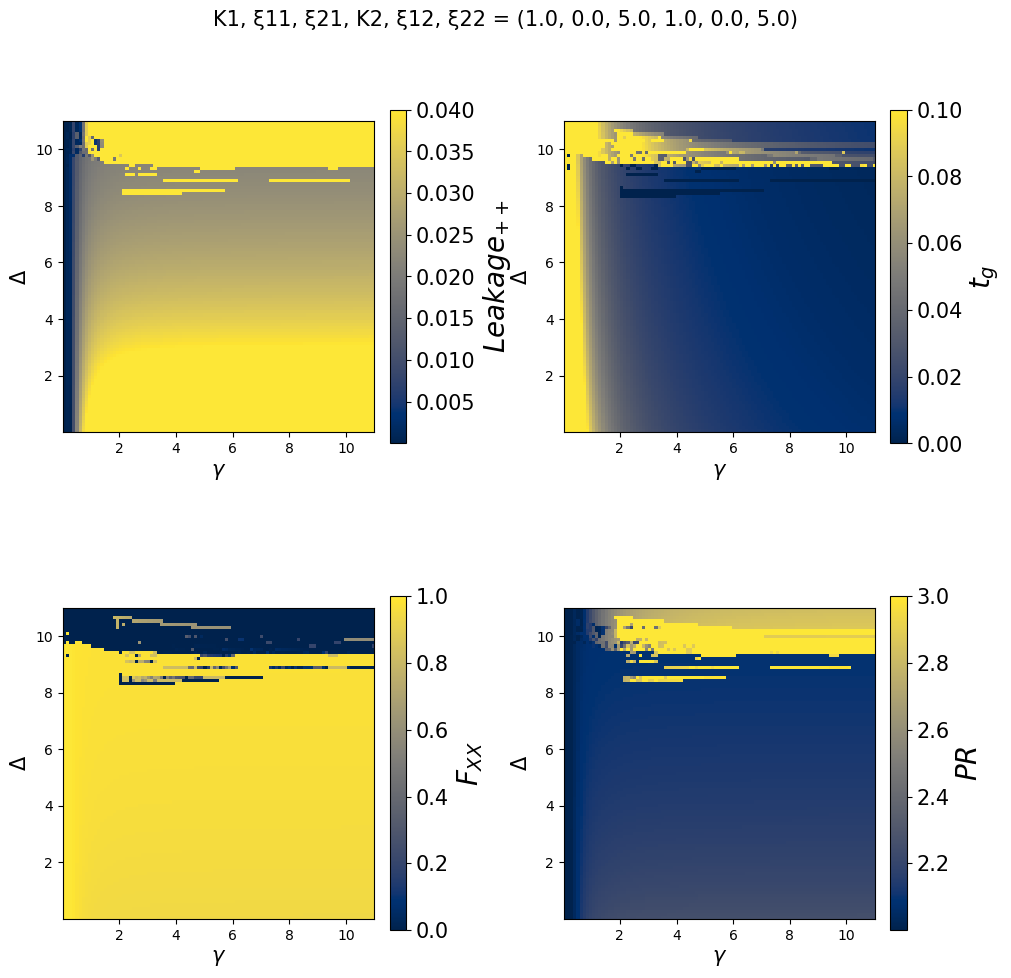

PyObject Text(0.5, 0.995833, 'K1, ξ11, ξ21, K2, ξ12, ξ22 = (1.0, 0.0, 5.0, 1.0, 0.0, 5.0)')

In [11]:
fig = figure(figsize=(10,10), layout= "constrained");
gs = fig.add_gridspec(2,2);
element(i,j) = get(gs, (i,j)); # starts at 0 to N-1
slice(i,j) = pycall(pybuiltin("slice"), PyObject, i,j);
cmap_ = "cividis"

ax = fig.add_subplot(element(0,0))
im = imshow(Leakage,origin="lower",cmap=cmap_, extent=(0.01,11., 0.01,11.), vmax = 0.04)
#im = imshow(Leakage,origin="lower",cmap=cmap_, extent=(0.01,11., 0.01,11.))
#cax_ = fig.add_axes([0.96, 0.05, 0.02, 0.905]) 
cbar = plt.colorbar(im, shrink=0.7)#, cax = cax_)
cbar.ax.tick_params(labelsize=15)
cbar.set_label(L"Leakage_{++}", fontsize=20)
#bar = colorbar(CS,location="top", ticks=custom_ticks, shrink=0.9)
#cbar.ax.tick_params(axis="x", labelsize=15)
ylabel(L"Δ", fontsize=15);
xlabel(L"γ", fontsize=15);

ax = fig.add_subplot(element(1,0))
im = imshow(F,origin="lower",cmap=cmap_, extent=(0.01,11., 0.01,11.), vmax = 1)
#cax_ = fig.add_axes([0.96, 0.05, 0.02, 0.905]) 
cbar = plt.colorbar(im, shrink=0.7)#, cax = cax_)
cbar.ax.tick_params(labelsize=15)
cbar.set_label(L"F_{XX}", fontsize=20)
#bar = colorbar(CS,location="top", ticks=custom_ticks, shrink=0.9)
#cbar.ax.tick_params(axis="x", labelsize=15)
ylabel(L"Δ", fontsize=15);
xlabel(L"γ", fontsize=15);

ax = fig.add_subplot(element(0,1))
im = imshow(ts_gate,origin="lower",cmap=cmap_, extent=(0.01,11., 0.01,11.),vmax = .1, vmin = 0)
#cax_ = fig.add_axes([0.96, 0.05, 0.02, 0.905]) 
cbar = plt.colorbar(im, shrink=0.7)#, cax = cax_)
cbar.ax.tick_params(labelsize=15)
cbar.set_label(L"t_{g}", fontsize=20)
#bar = colorbar(CS,location="top", ticks=custom_ticks, shrink=0.9)
#cbar.ax.tick_params(axis="x", labelsize=15)
ylabel(L"Δ", fontsize=15);
xlabel(L"γ", fontsize=15);

ax = fig.add_subplot(element(1,1))
im = imshow(PR_sum,origin="lower",cmap=cmap_, extent=(0.01,11., 0.01,11.), vmax = 3)
#cax_ = fig.add_axes([0.96, 0.05, 0.02, 0.905]) 
cbar = plt.colorbar(im, shrink=0.7)#, cax = cax_)
cbar.ax.tick_params(labelsize=15)
cbar.set_label(L"PR", fontsize=20)
#bar = colorbar(CS,location="top", ticks=custom_ticks, shrink=0.9)
#cbar.ax.tick_params(axis="x", labelsize=15)
ylabel(L"Δ", fontsize=15);
xlabel(L"γ", fontsize=15);

fig.suptitle("K1, ξ11, ξ21, K2, ξ12, ξ22 = $((K1, ξ11, ξ21, K2, ξ12, ξ22))", fontsize=15);
#savefig("C:/Users/edson/Desktop/Research/Kerr_system/Coupled_kerr/codes_Chemistry/Quantum_figures/Scrambling/Scrambling_Qubits_chaos_p_$((K1, ξ11, ξ21, K2, ξ12, ξ22))_$(N)_γΔ.png")                